In [2]:
import torch
import torchvision
from torch import nn, optim
from  torchvision import datasets, transforms
import torch.nn.functional as F

import time
epoch = 50

import numpy as np
import matplotlib.pyplot as plt

from utils_cifar10 import *
from models import VGG

In [3]:
train_transform = transforms.Compose([
    #     transforms.CenterCrop(224),
        transforms.RandomCrop(32,padding=4),
        transforms.RandomHorizontalFlip(), 
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
    
    
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

In [4]:
batch_size = 64

In [5]:
trainset = datasets.CIFAR10(root='./data', train=True,download=True, transform=train_transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=test_transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [6]:
classes = trainset.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [7]:
trainset.class_to_idx

{'airplane': 0,
 'automobile': 1,
 'bird': 2,
 'cat': 3,
 'deer': 4,
 'dog': 5,
 'frog': 6,
 'horse': 7,
 'ship': 8,
 'truck': 9}

In [8]:
print(trainset.data.shape)
print(type(trainset.data))
print(type(trainset))

(50000, 32, 32, 3)
<class 'numpy.ndarray'>
<class 'torchvision.datasets.cifar.CIFAR10'>


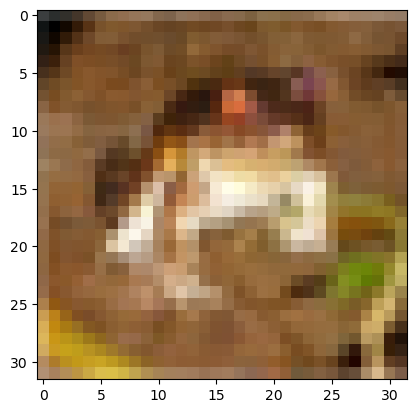

In [9]:

plt.imshow(trainset.data[0])
im,label = next(iter(trainloader))

In [10]:
def imshow(img):
    img = img / 2 + 0.5
    img = np.transpose(img.numpy(),(1,2,0))
    plt.imshow(img)

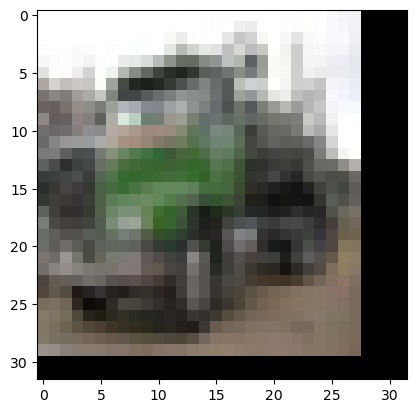

In [11]:
im[0].shape
imshow(im[0])

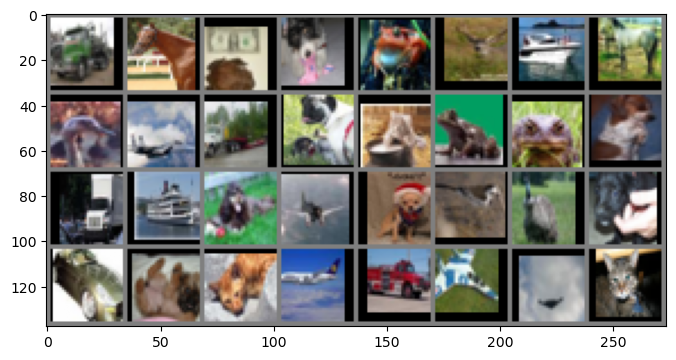

In [12]:
plt.figure(figsize=(8,12))
imshow(torchvision.utils.make_grid(im[:32]))

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [14]:
net = VGG('VGG19').to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [15]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [16]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [  1/ 50] | Train Loss:1.928439 | Train Acc:20.03% | Test Loss:1.808595 | Test Acc:24.52% | Learning Rate:0.001000
Epoch [  2/ 50] | Train Loss:1.714476 | Train Acc:30.78% | Test Loss:1.626630 | Test Acc:32.93% | Learning Rate:0.001000
Epoch [  3/ 50] | Train Loss:1.452733 | Train Acc:42.59% | Test Loss:1.374831 | Test Acc:46.84% | Learning Rate:0.001000
Epoch [  4/ 50] | Train Loss:1.248360 | Train Acc:54.56% | Test Loss:1.135073 | Test Acc:57.73% | Learning Rate:0.001000
Epoch [  5/ 50] | Train Loss:1.093742 | Train Acc:60.34% | Test Loss:0.994044 | Test Acc:64.60% | Learning Rate:0.001000
Epoch [  6/ 50] | Train Loss:1.000465 | Train Acc:65.26% | Test Loss:0.985016 | Test Acc:66.70% | Learning Rate:0.001000
Epoch [  7/ 50] | Train Loss:0.927407 | Train Acc:68.65% | Test Loss:0.909658 | Test Acc:69.03% | Learning Rate:0.001000
Epoch [  8/ 50] | Train Loss:0.839814 | Train Acc:71.84% | Test Loss:0.817230 | Test Acc:71.04% | Learning Rate:0.001000
Epoch [  9/ 50] | Train Loss:0.7

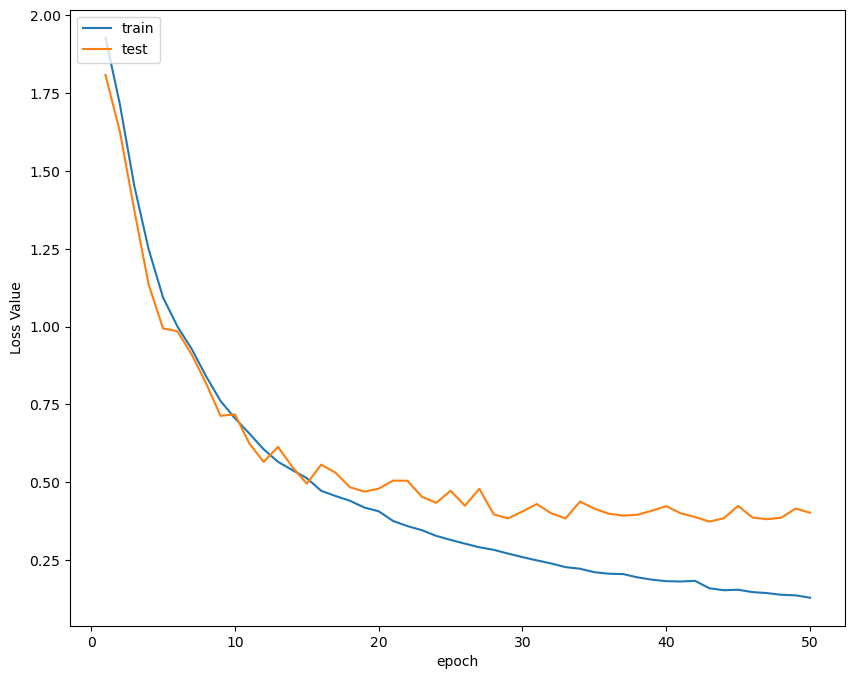

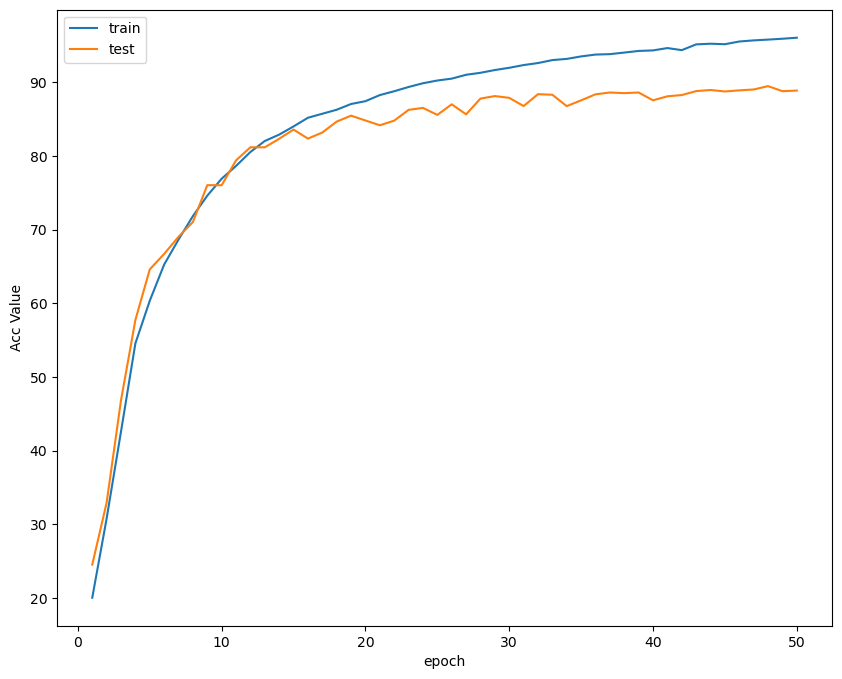

In [17]:
plot_history(epoch, Acc, Loss)

In [18]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=0)
net.eval()
for data in testloader: # Loop through each batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval() # Convert the model to test mode
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images) # Enter the network for testing
    
    # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0) # update the number of test images
    correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 88.94 %


In [19]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 92.40 %
Accuracy of automobile : 93.10 %
Accuracy of  bird : 83.30 %
Accuracy of   cat : 76.50 %
Accuracy of  deer : 90.40 %
Accuracy of   dog : 77.70 %
Accuracy of  frog : 93.80 %
Accuracy of horse : 91.90 %
Accuracy of  ship : 94.90 %
Accuracy of truck : 95.40 %


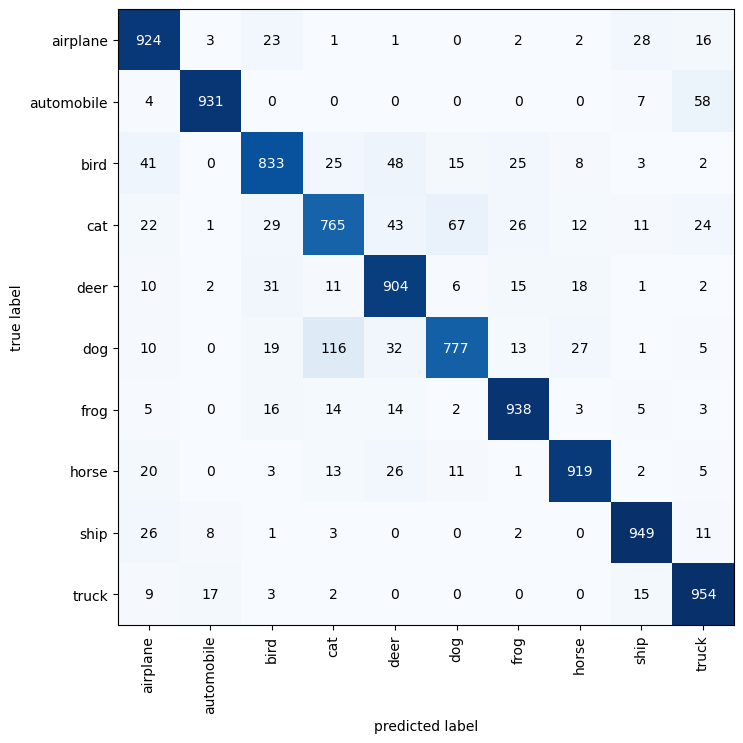

In [20]:
import numpy as np
from itertools import product


class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 87.5%


<Figure size 2500x400 with 0 Axes>

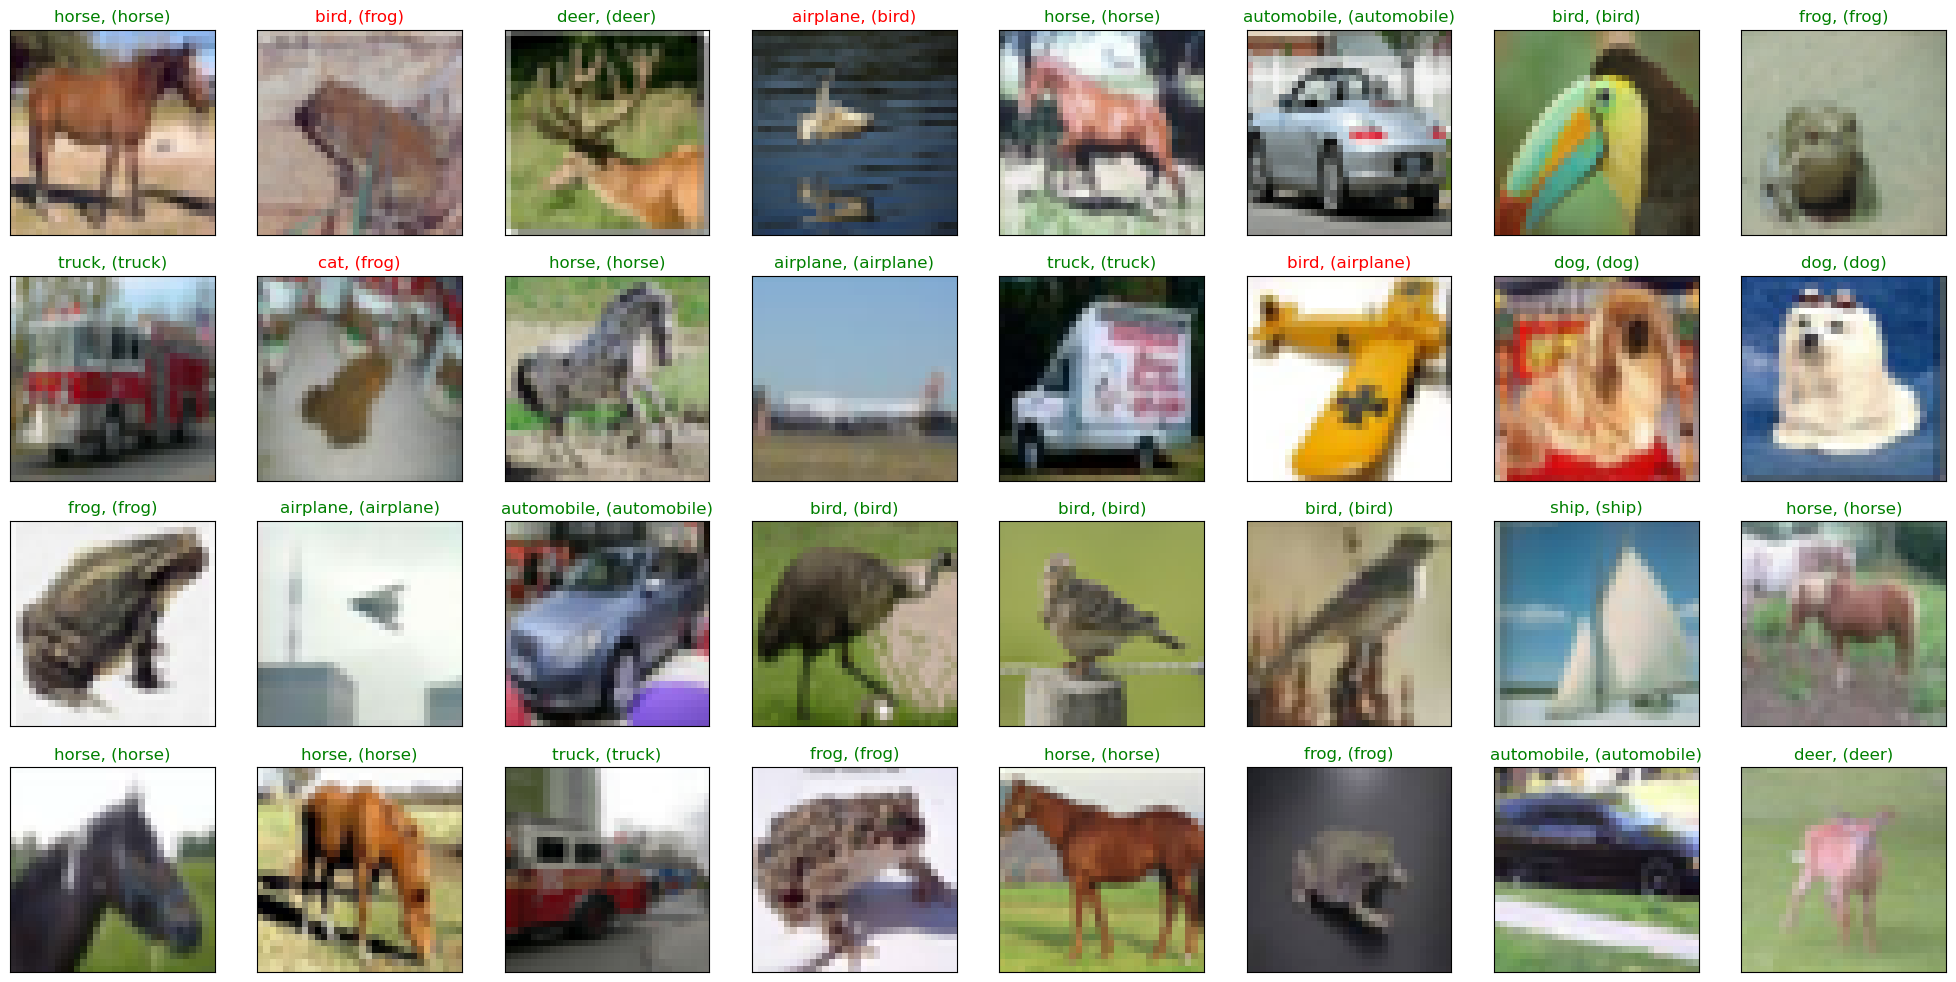

In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

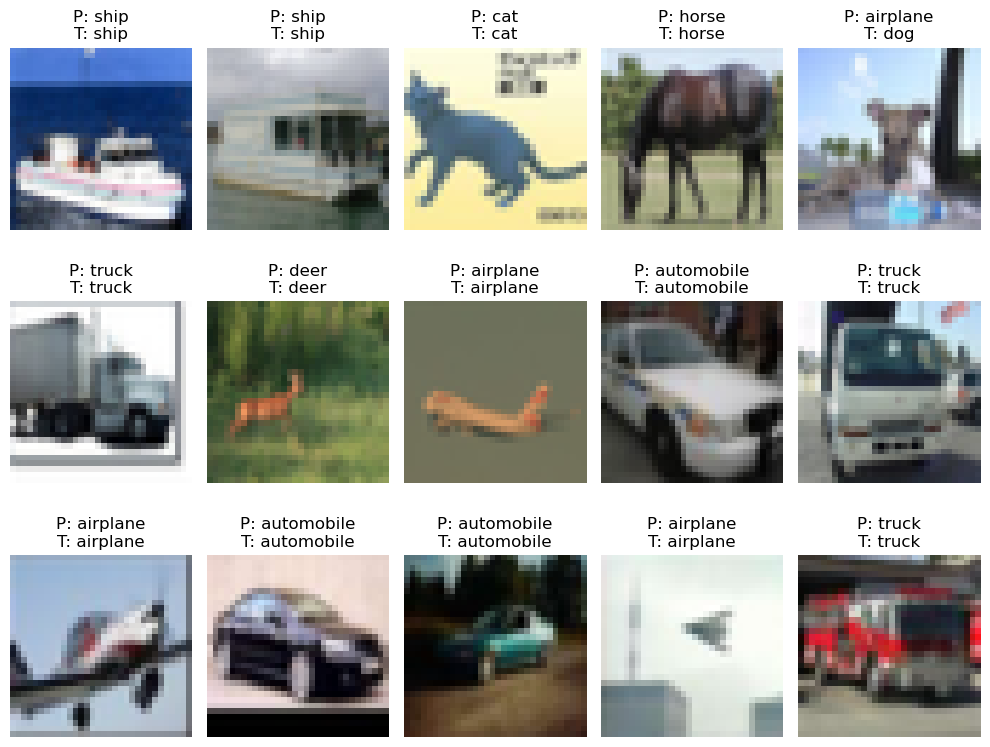

In [22]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## VGG19 SGD

In [14]:
net = VGG('VGG19').to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [15]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, verbose=True, patience=5, min_lr=1e-5) 

criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [16]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion, scheduler)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch [  1/ 50] | Train Loss:2.225462 | Train Acc:13.48% | Test Loss:2.029490 | Test Acc:18.77% | Learning Rate:0.001000 | Time: 00:42
Epoch [  2/ 50] | Train Loss:1.826430 | Train Acc:24.73% | Test Loss:1.661545 | Test Acc:32.16% | Learning Rate:0.001000 | Time: 00:40
Epoch [  3/ 50] | Train Loss:1.544798 | Train Acc:40.00% | Test Loss:1.366258 | Test Acc:47.15% | Learning Rate:0.001000 | Time: 00:40
Epoch [  4/ 50] | Train Loss:1.304438 | Train Acc:51.72% | Test Loss:1.136980 | Test Acc:58.02% | Learning Rate:0.001000 | Time: 00:40
Epoch [  5/ 50] | Train Loss:1.103686 | Train Acc:60.30% | Test Loss:0.983595 | Test Acc:64.82% | Learning Rate:0.001000 | Time: 00:39
Epoch [  6/ 50] | Train Loss:0.961851 | Train Acc:65.81% | Test Loss:0.908578 | Test Acc:67.49% | Learning Rate:0.001000 | Time: 00:39
Epoch [  7/ 50] | Train Loss:0.852357 | Train Acc:69.96% | Test Loss:0.764616 | Test Acc:73.32% | Learning Rate:0.001000 | Time: 00:39
Epoch [  8/ 50] | Train Loss:0.770805 | Train Acc:73.13

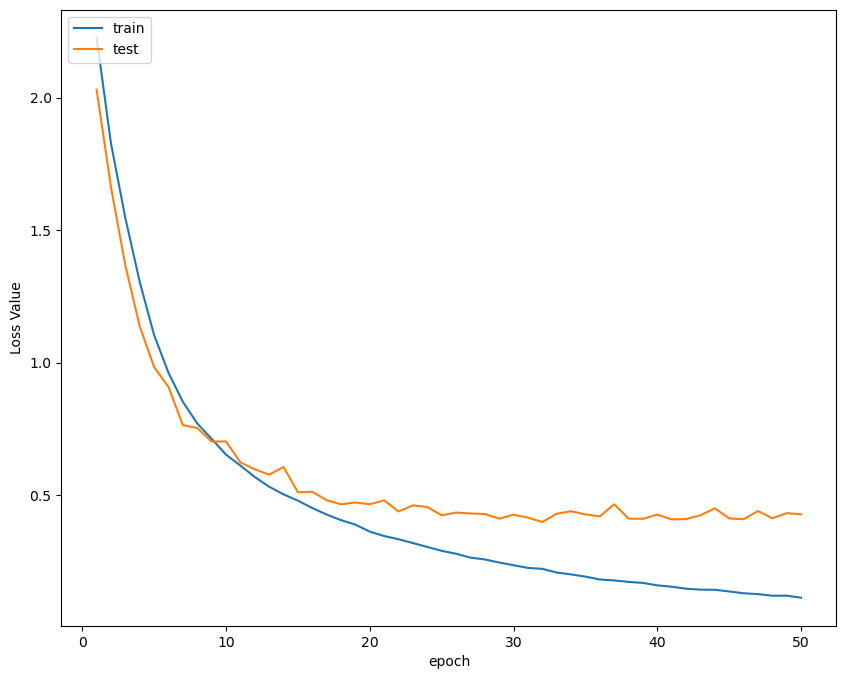

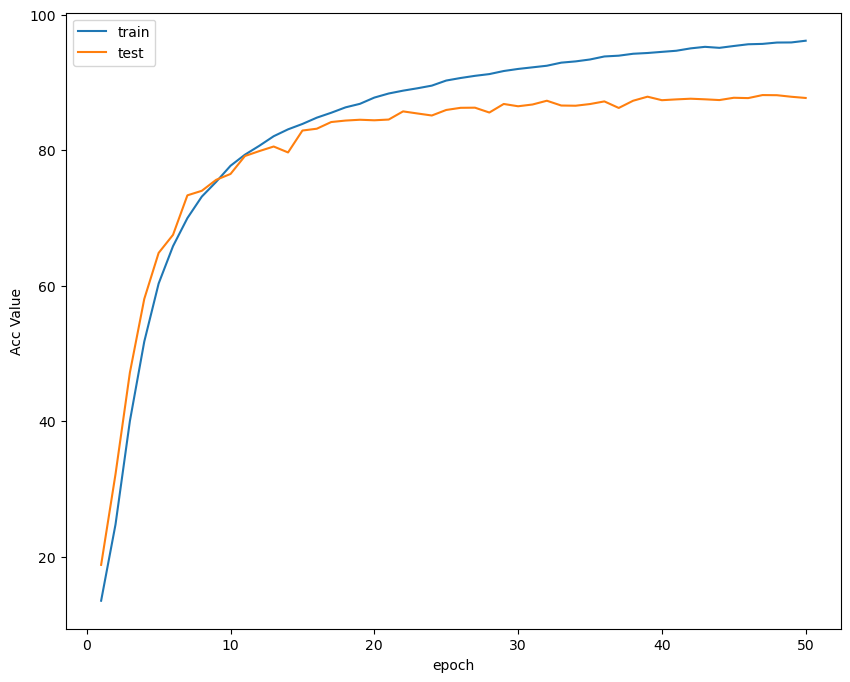

In [17]:
plot_history(epoch, Acc, Loss)

In [18]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=0)
net.eval()
for data in testloader: # Loop through each batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval() # Convert the model to test mode
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images) # Enter the network for testing
    
    # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0) # update the number of test images
    correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 87.68 %


In [19]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 81.20 %
Accuracy of automobile : 96.00 %
Accuracy of  bird : 83.70 %
Accuracy of   cat : 78.40 %
Accuracy of  deer : 91.50 %
Accuracy of   dog : 84.70 %
Accuracy of  frog : 89.40 %
Accuracy of horse : 89.40 %
Accuracy of  ship : 94.80 %
Accuracy of truck : 87.70 %


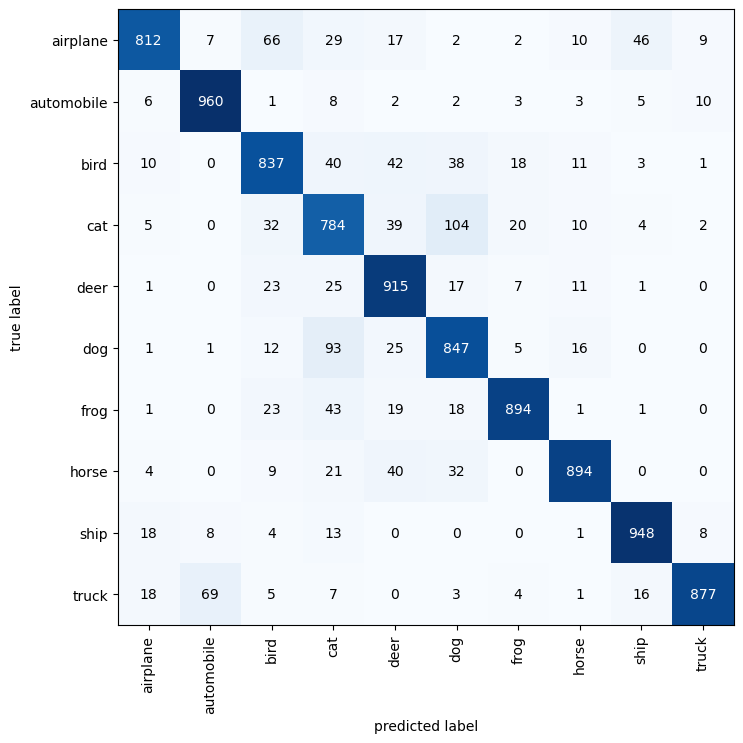

In [20]:
import numpy as np
from itertools import product


class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 90.625%


<Figure size 2500x400 with 0 Axes>

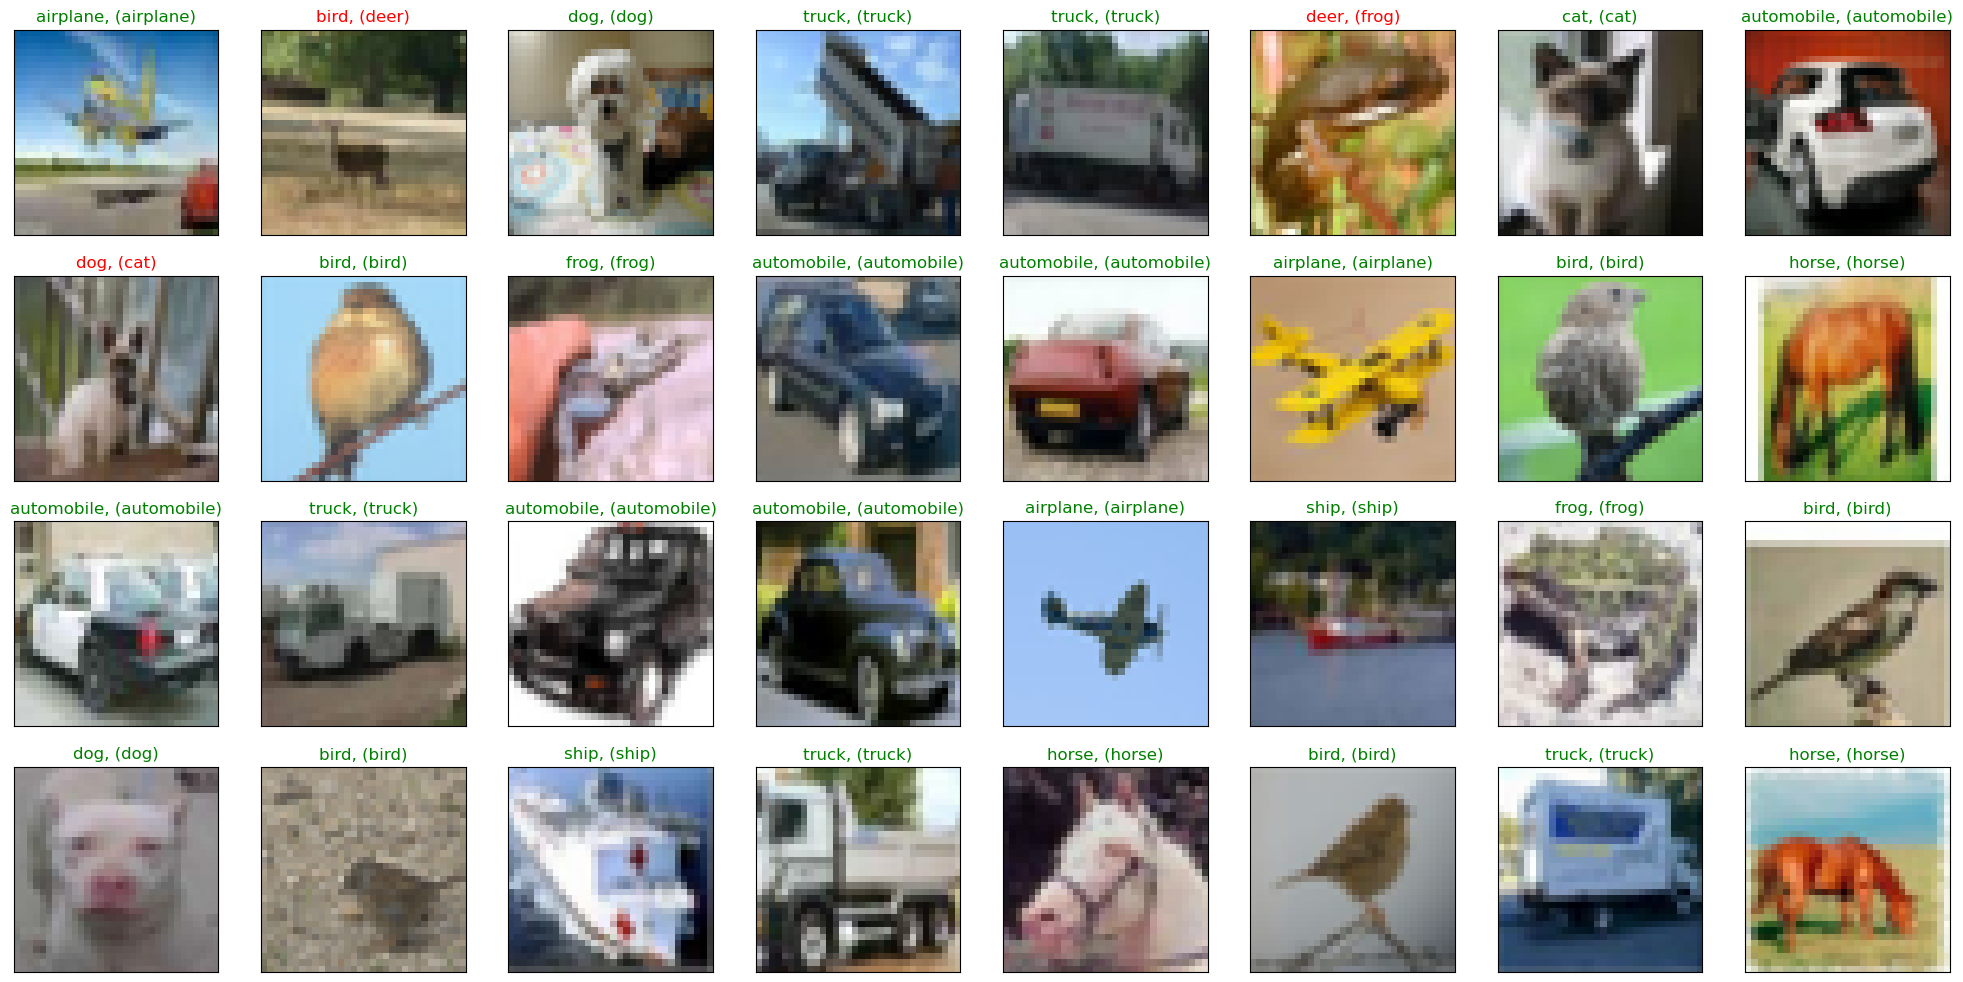

In [21]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

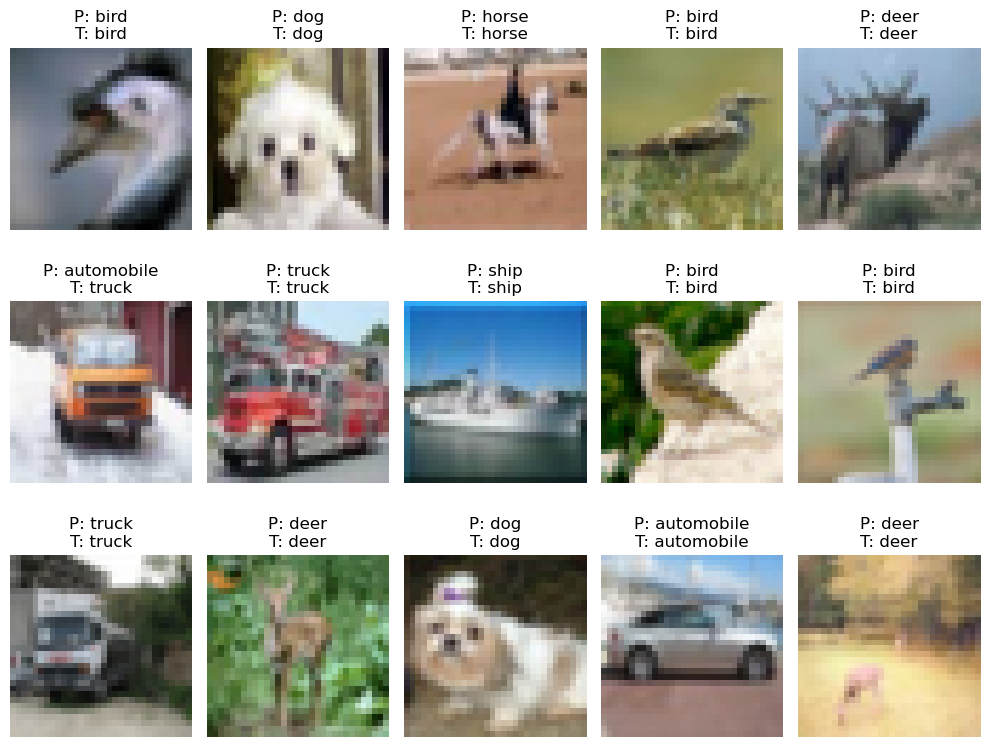

In [22]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## VGG16 ADAM

In [23]:
net = VGG('VGG16').to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [24]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [25]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion)

Epoch [  1/ 50] | Train Loss:1.900687 | Train Acc:20.62% | Test Loss:1.761075 | Test Acc:29.43% | Learning Rate:0.001000 | Time: 00:40
Epoch [  2/ 50] | Train Loss:1.585433 | Train Acc:36.73% | Test Loss:1.368658 | Test Acc:45.77% | Learning Rate:0.001000 | Time: 00:40
Epoch [  3/ 50] | Train Loss:1.299640 | Train Acc:51.67% | Test Loss:1.195627 | Test Acc:56.94% | Learning Rate:0.001000 | Time: 00:40
Epoch [  4/ 50] | Train Loss:1.056310 | Train Acc:61.89% | Test Loss:1.047334 | Test Acc:61.89% | Learning Rate:0.001000 | Time: 00:40
Epoch [  5/ 50] | Train Loss:0.920736 | Train Acc:67.67% | Test Loss:0.828546 | Test Acc:70.27% | Learning Rate:0.001000 | Time: 00:40
Epoch [  6/ 50] | Train Loss:0.827851 | Train Acc:71.54% | Test Loss:0.761088 | Test Acc:73.67% | Learning Rate:0.001000 | Time: 00:40
Epoch [  7/ 50] | Train Loss:0.748113 | Train Acc:75.00% | Test Loss:0.711263 | Test Acc:76.53% | Learning Rate:0.001000 | Time: 00:40
Epoch [  8/ 50] | Train Loss:0.685139 | Train Acc:77.34

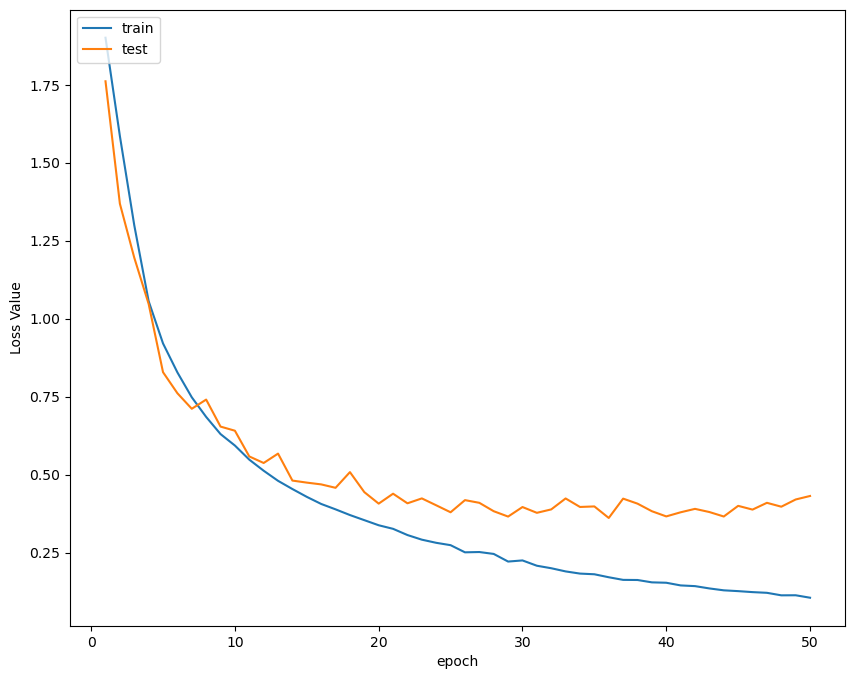

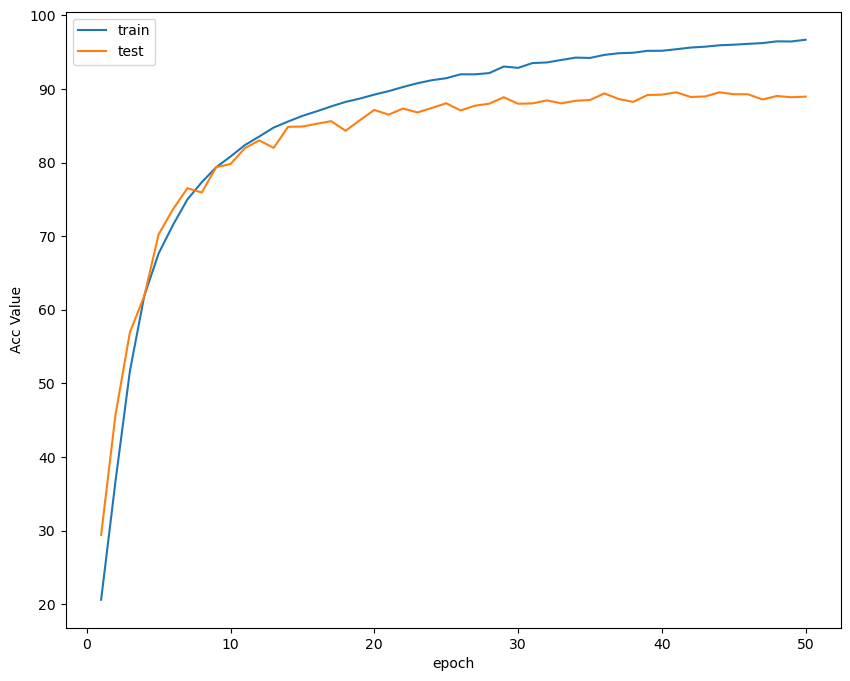

In [26]:
plot_history(epoch, Acc, Loss)

In [27]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=True, num_workers=0)
net.eval()
for data in testloader: # Loop through each batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval() # Convert the model to test mode
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images) # Enter the network for testing
    
    # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0) # update the number of test images
    correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 88.97 %


In [28]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 88.70 %
Accuracy of automobile : 94.70 %
Accuracy of  bird : 82.80 %
Accuracy of   cat : 84.80 %
Accuracy of  deer : 81.10 %
Accuracy of   dog : 84.50 %
Accuracy of  frog : 92.10 %
Accuracy of horse : 93.30 %
Accuracy of  ship : 94.60 %
Accuracy of truck : 93.10 %


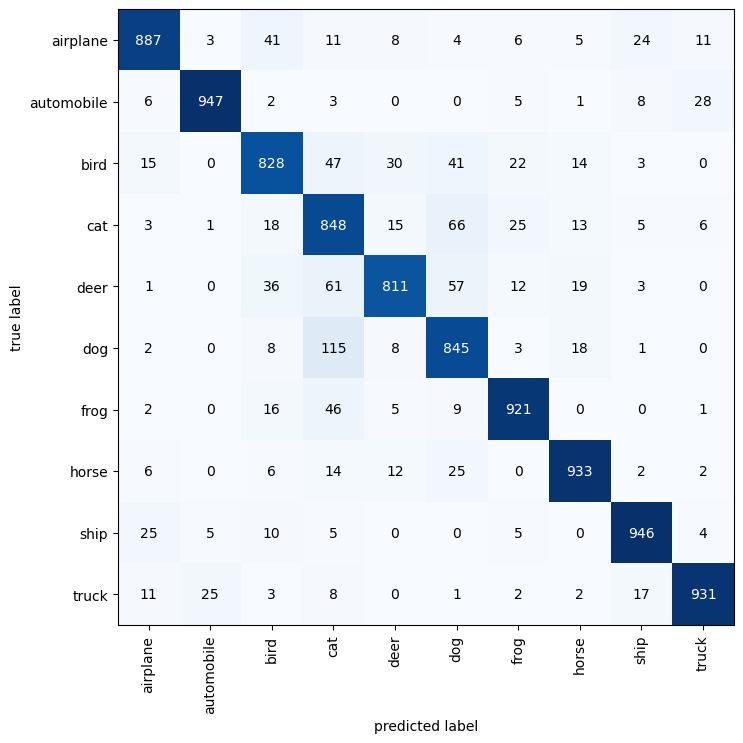

In [29]:
import numpy as np
from itertools import product


class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 93.75%


<Figure size 2500x400 with 0 Axes>

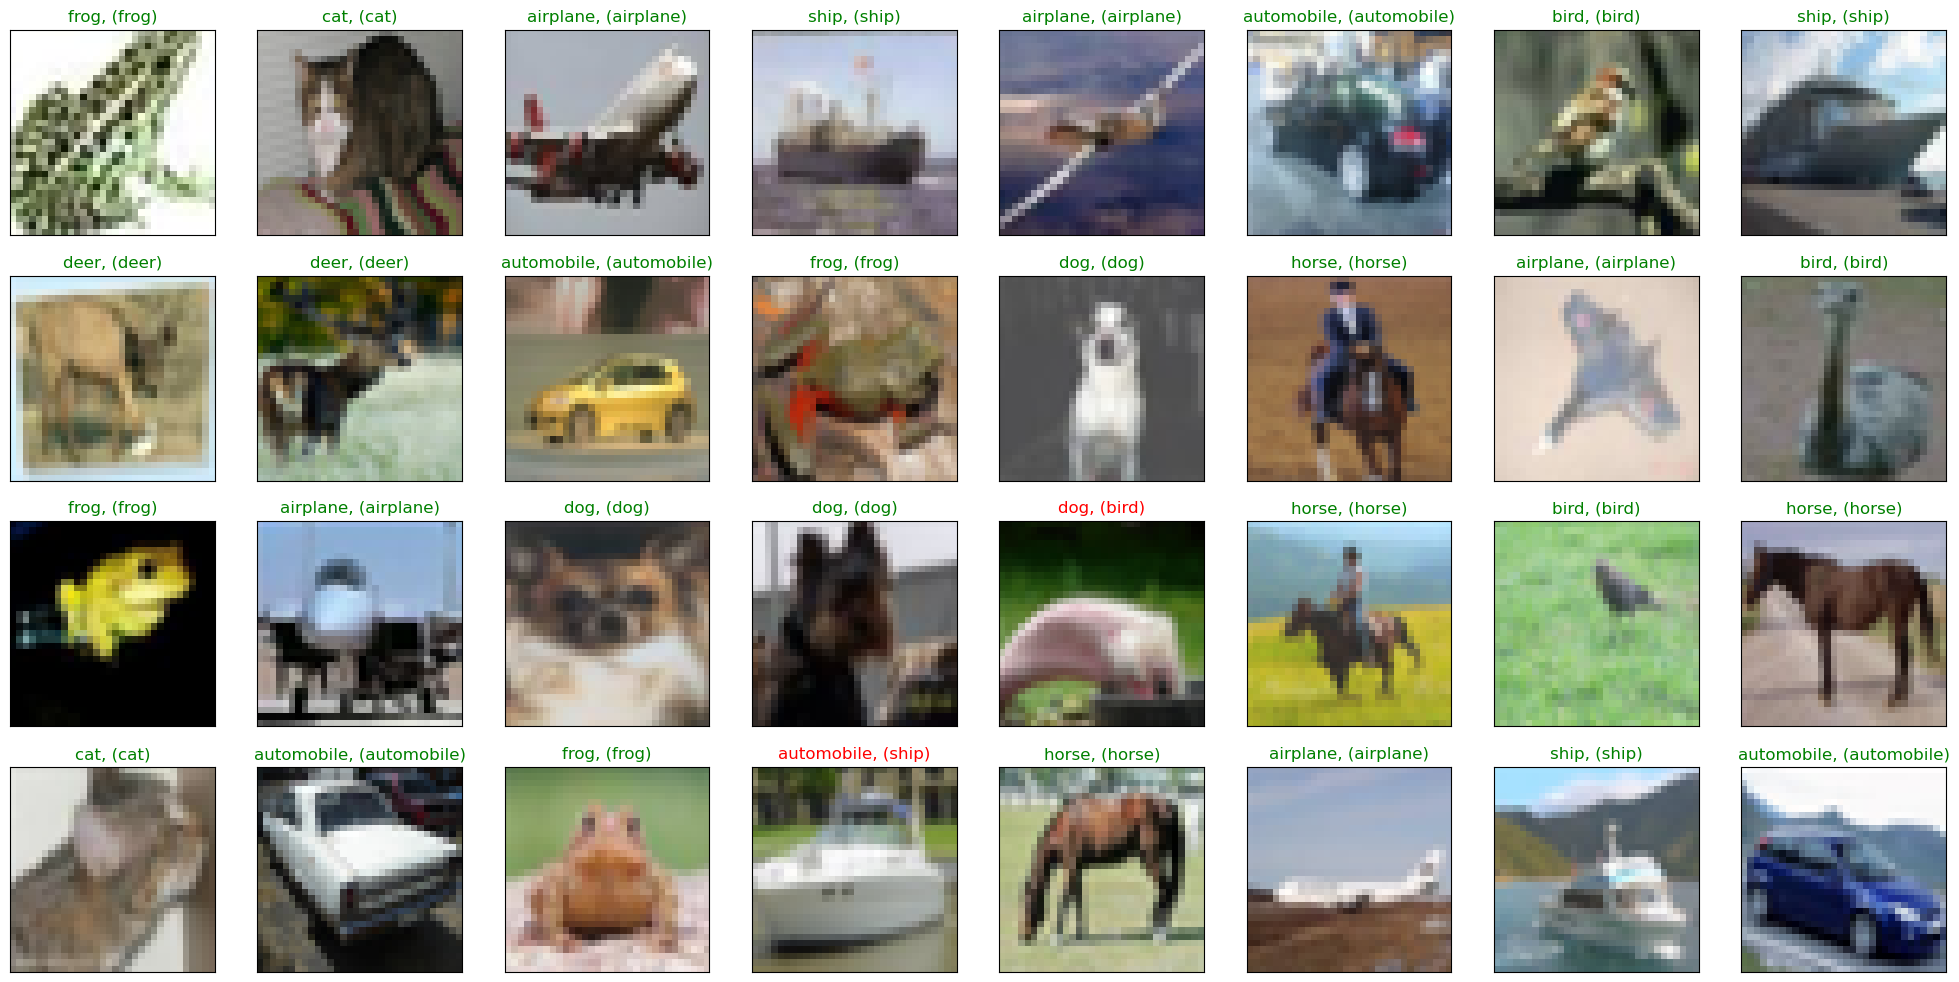

In [30]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

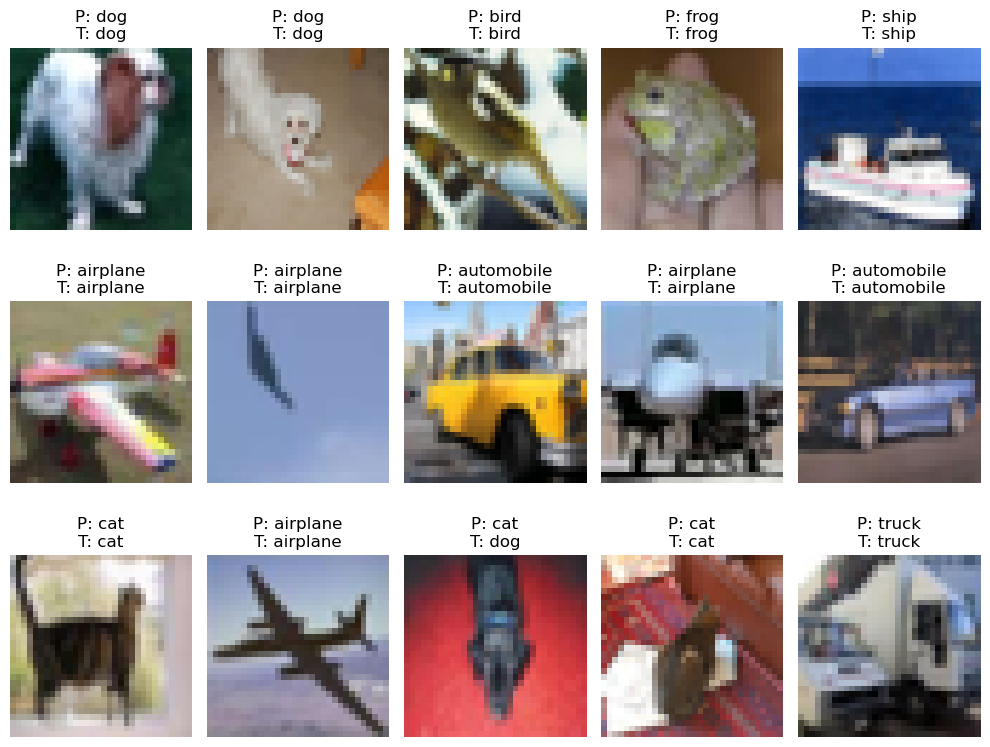

In [31]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)

## VGG16 SGD

In [32]:
net = VGG('VGG16').to(device)
if device == 'cuda':
    net = nn.DataParallel(net)
    torch.backends.cudnn.benchmark = True

In [33]:
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5,verbose=True,patience = 5,min_lr = 1e-5)

criterion = nn.CrossEntropyLoss()

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [34]:
Acc, Loss, Lr = train(net, trainloader, testloader, epoch, optimizer, criterion)

Epoch [  1/ 50] | Train Loss:1.717693 | Train Acc:33.36% | Test Loss:1.449842 | Test Acc:48.13% | Learning Rate:0.010000 | Time: 00:37
Epoch [  2/ 50] | Train Loss:1.121010 | Train Acc:60.26% | Test Loss:0.924766 | Test Acc:67.59% | Learning Rate:0.010000 | Time: 00:37
Epoch [  3/ 50] | Train Loss:0.860182 | Train Acc:70.38% | Test Loss:0.838711 | Test Acc:72.16% | Learning Rate:0.010000 | Time: 00:38
Epoch [  4/ 50] | Train Loss:0.726710 | Train Acc:75.43% | Test Loss:0.719187 | Test Acc:76.25% | Learning Rate:0.010000 | Time: 00:37
Epoch [  5/ 50] | Train Loss:0.634489 | Train Acc:78.73% | Test Loss:0.608601 | Test Acc:79.76% | Learning Rate:0.010000 | Time: 00:37
Epoch [  6/ 50] | Train Loss:0.569186 | Train Acc:80.83% | Test Loss:0.615115 | Test Acc:79.74% | Learning Rate:0.010000 | Time: 00:37
Epoch [  7/ 50] | Train Loss:0.526180 | Train Acc:82.58% | Test Loss:0.611773 | Test Acc:80.03% | Learning Rate:0.010000 | Time: 00:37
Epoch [  8/ 50] | Train Loss:0.488029 | Train Acc:83.69

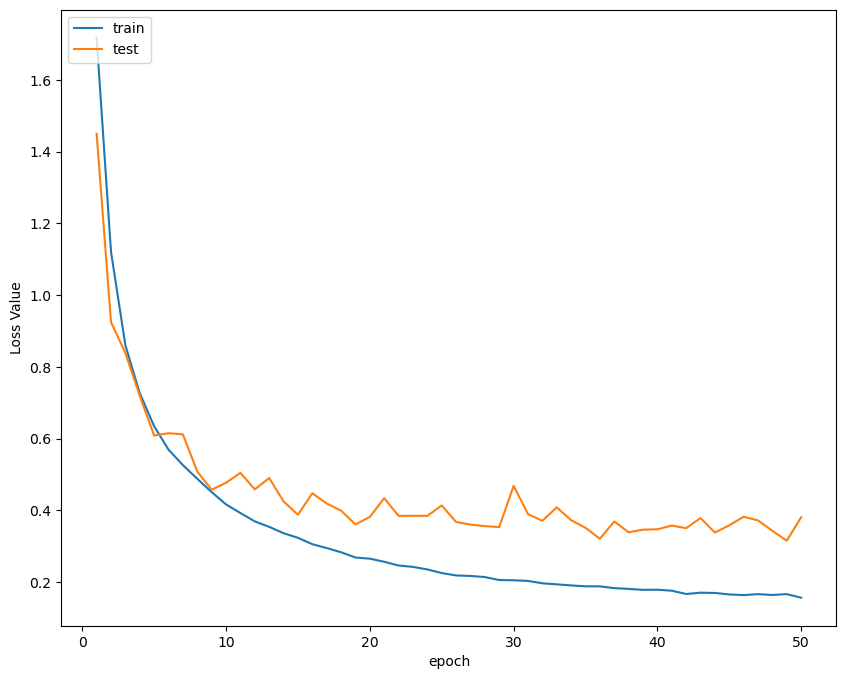

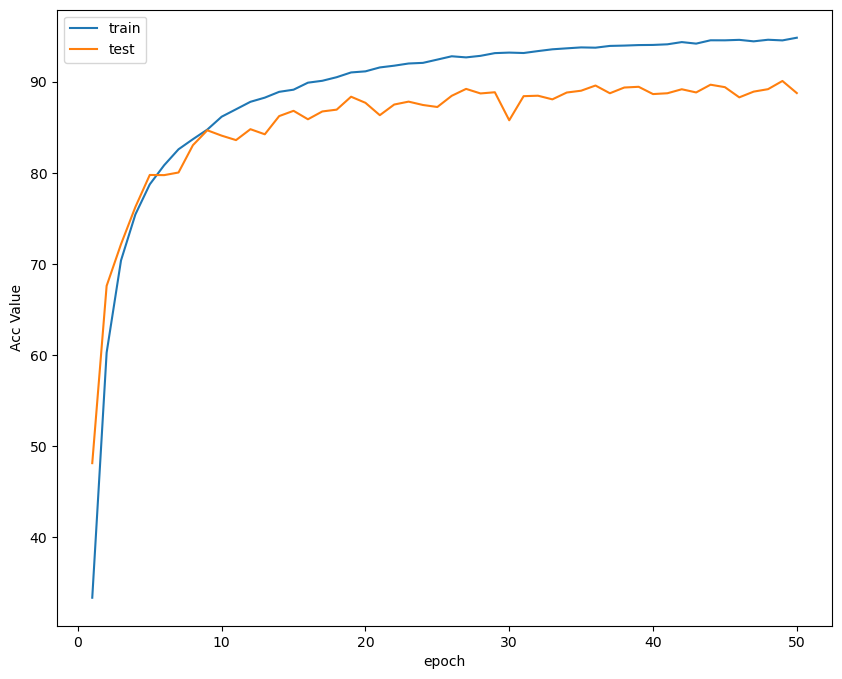

In [35]:
plot_history(epoch, Acc, Loss)

In [41]:
correct = 0 # Define the number of correctly predicted images, initialized to 0
total = 0 # The total number of pictures participating in the test, also initialized to 0
testloader = torch.utils.data.DataLoader(testset, batch_size=32,shuffle=False, num_workers=0)
net.eval()
for data in testloader: # Loop through each batch
    images, labels = data
    images = images.to(device)
    labels = labels.to(device)
    net.eval() # Convert the model to test mode
    if hasattr(torch.cuda, 'empty_cache'):
        torch.cuda.empty_cache()
    outputs = net(images) # Enter the network for testing
    
    # outputs.data is a 4x10 tensor. The value and sequence number of the largest column of each row are formed into a one-dimensional tensor to return, the first is the value tensor, and the second is the sequence number tensor.
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0) # update the number of test images
    correct += (predicted == labels).sum() # update the number of correctly classified images

print('Accuracy of the network on the 10000 test images: %.2f %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 88.74 %


In [42]:
# Define 2 lists that store the number of correct tests in each class, initialized to 0
class_correct = list(0.for i in range(10))
class_total = list(0.for i in range(10))
# testloader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True, num_workers=2)
net.eval()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)
        if hasattr(torch.cuda, 'empty_cache'):
            torch.cuda.empty_cache()
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
    #4 group (batch_size) data, output in the same label, marked as 1, otherwise 0
        c = (predicted == labels).squeeze()
        for i in range(len(images)): # Because each batch has 4 images, a small loop of 4 is needed
            label = labels[i] # Accumulate each class separately
            class_correct[label] += c[i]
            class_total[label] += 1
 
 
for i in range(10):
    print('Accuracy of %5s : %.2f %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 92.80 %
Accuracy of automobile : 91.50 %
Accuracy of  bird : 82.30 %
Accuracy of   cat : 67.90 %
Accuracy of  deer : 87.40 %
Accuracy of   dog : 88.60 %
Accuracy of  frog : 95.50 %
Accuracy of horse : 93.70 %
Accuracy of  ship : 96.30 %
Accuracy of truck : 91.40 %


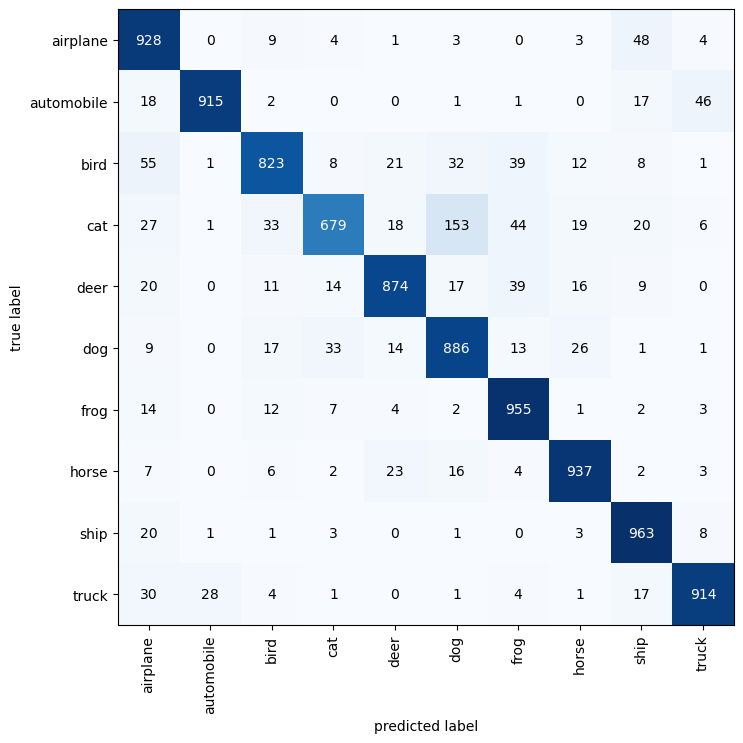

In [38]:
import numpy as np
from itertools import product


class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=net, data_loader=testloader, device=torch.device('cpu'))
plot_confusion_matrix(mat, class_names=class_dict.values())
plt.show()

Accuracy Rate = 90.625%


<Figure size 2500x400 with 0 Axes>

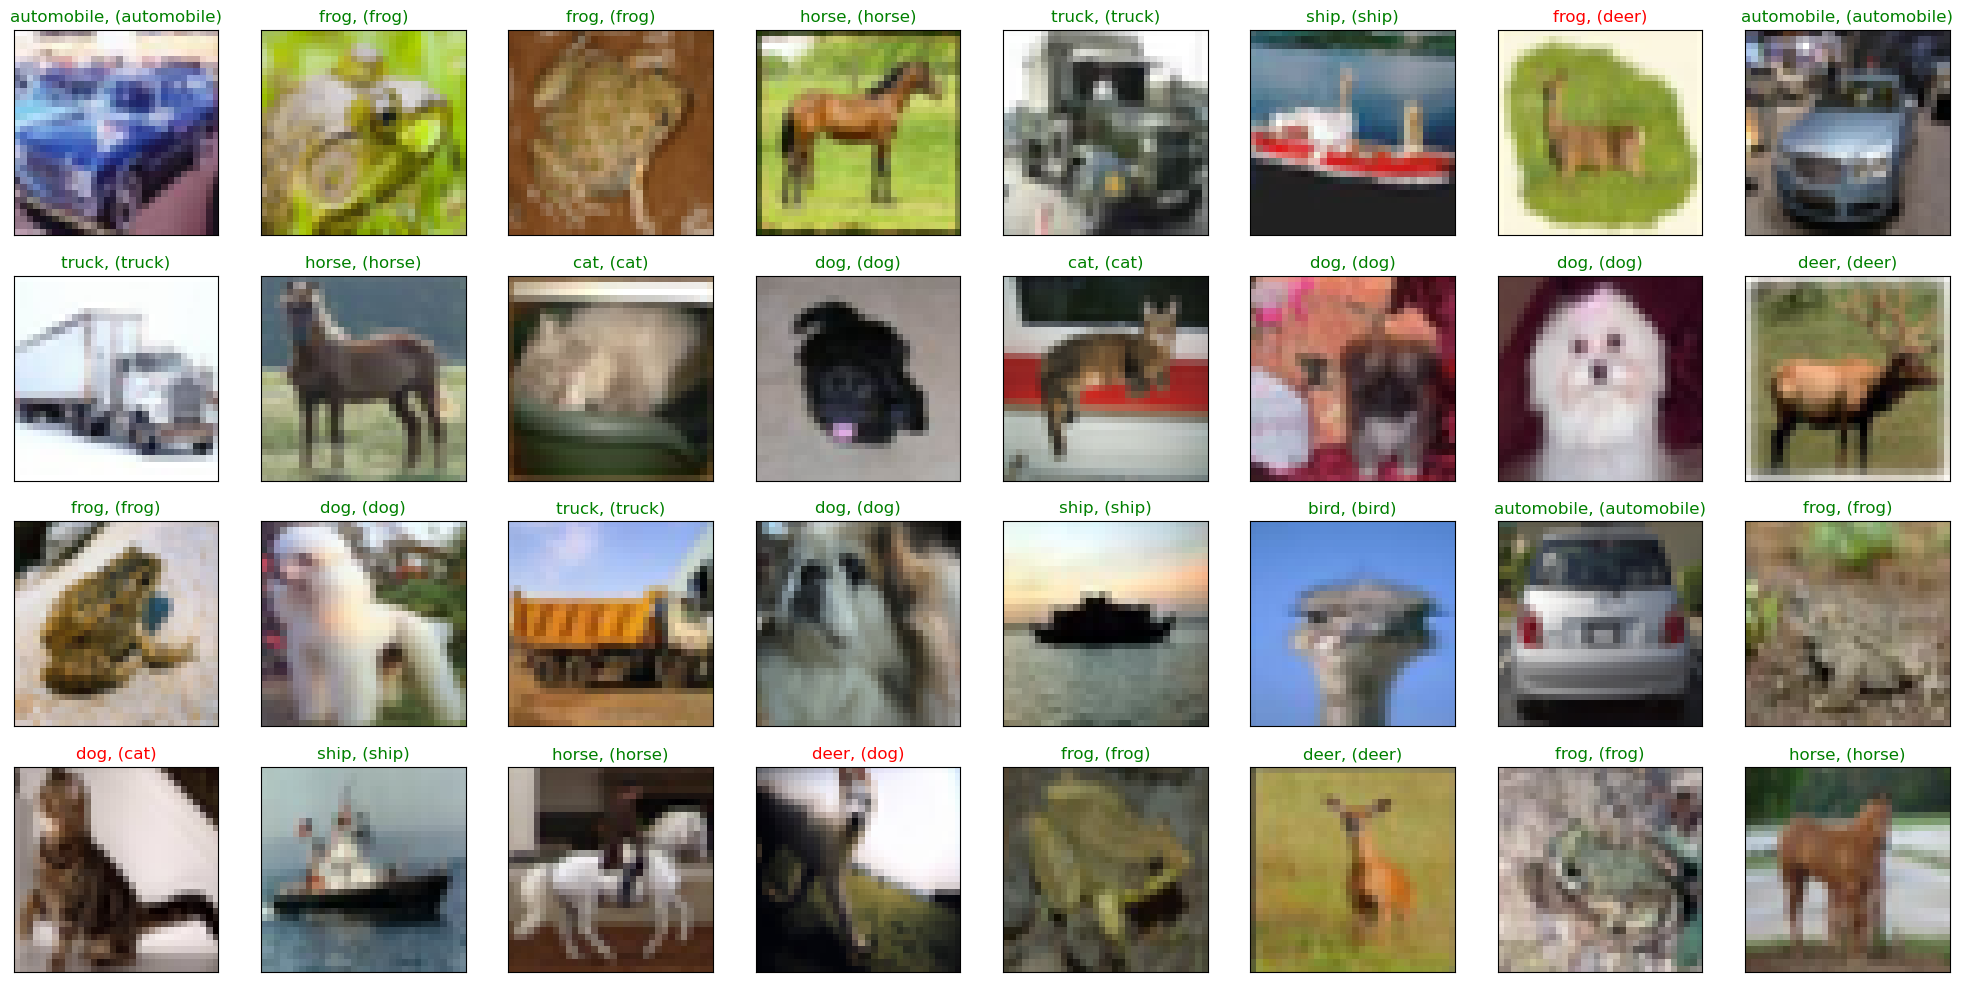

In [39]:
dataiter = iter(testloader)
images, labels = next(dataiter)
images_ = images
images_ = images_.to(device)
labels = labels.to(device)
val_output = net(images_)
_, val_preds = torch.max(val_output, 1)

fig = plt.figure(figsize=(25,4))

correct = torch.sum(val_preds == labels.data).item()

val_preds = val_preds.cpu()
labels = labels.cpu()

print("Accuracy Rate = {}%".format(correct/len(images) * 100))

fig = plt.figure(figsize=(25,25))
for idx in np.arange(32):    
    ax = fig.add_subplot(8, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(
        "{}, ({})".format(classes[val_preds[idx].item()], classes[labels[idx].item()]), 
        color = ("green" if val_preds[idx].item()==labels[idx].item() else "red")
    )

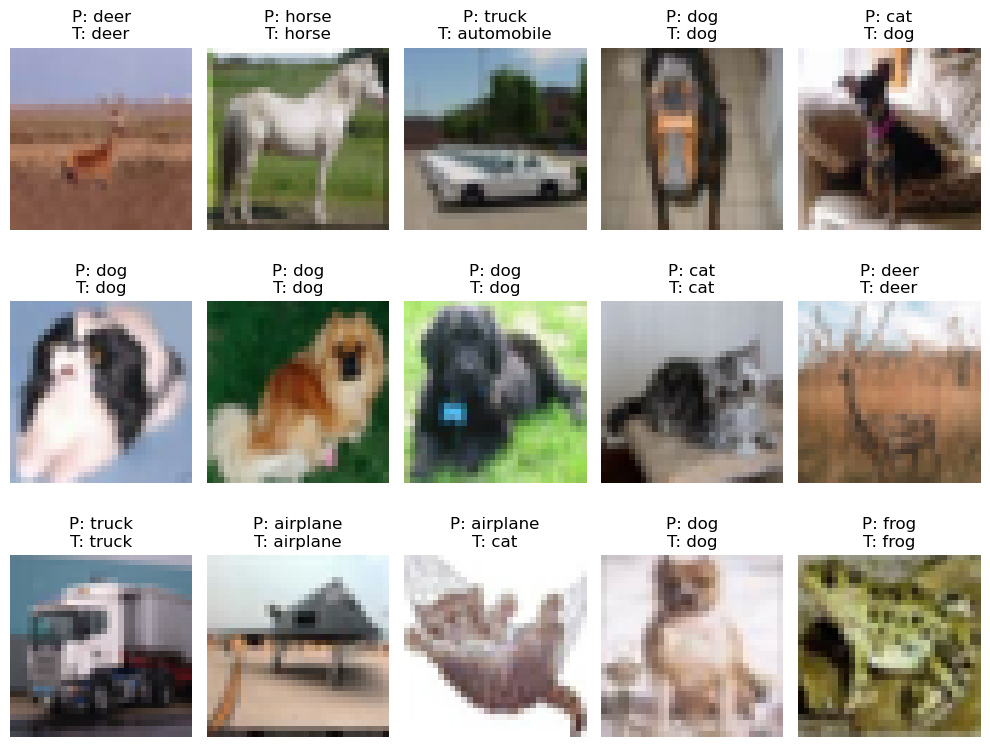

In [40]:
unnormalizer = UnNormalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

show_examples(model=net, data_loader=testloader, unnormalizer=unnormalizer, class_dict=class_dict)